<a href="https://colab.research.google.com/github/MarkStephens060482/Big-Data-projects/blob/main/Severity_of_Road_Accidents_modelling%20and%20evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Severity of Road Accidents - Forming predictions for the imbalanced multiclass classification problem.
#### Mark Stephens

Install the relevant packages and import modules

In [ ]:
!pip install Boruta
!pip install category_encoders
!pip install hdbscan
!pip install gower
!pip install plotly==5.15.0
!pip install -U imbalanced-learn
!pip install -U yellowbrick
!pip install -U shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/5e/a0/b510b682cac4f2d0b25c05a490c0a689eb234d36edb42c96c885383f064a/shap-0.42.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/462.3 kB ? eta -:--:--
   ------- -------------------------------- 92.2/462.3 kB 2.6 MB/s eta 0:00:01
   ---------------- ----------------------- 194.6/462.3 kB 2.3 MB/s eta 0:00:01
   ----------------- ---------------------- 204.8/462.3 kB 2.1 MB/s eta 0:00:01
   --------------------------- ------------ 317.4/462.3 kB 1.8 MB/s eta 0:00:01
   ----------------------------------- ---- 409.6/462.3 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 462.3/462.3 kB 1.7 MB/s eta 0:00:00


In [ ]:
# import standard modules
import pandas as pd
import numpy as np
import os, glob
import json
from collections import Counter
import bz2
import pickle
import _pickle as cPickle
from time import perf_counter
from scipy.stats import uniform, randint
from random import sample

# mount G Drive
#from google.colab import drive
#drive.mount('/content/drive')
#graphing modules
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# preprocessing and pipeline packages
from pandas.api.types import CategoricalDtype
import category_encoders as ce
from sklearn.preprocessing import RobustScaler,StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

from sklearn import set_config

#class imbalance packages
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

#import model packages
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb

#import feature selection
from boruta import BorutaPy

#import model selection packages
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

#import  model evaluation packages
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from yellowbrick.classifier import ClassificationReport
from sklearn.inspection import permutation_importance
import shap

### Gather dataset and further cleaning
Open the processed dataset, cast ordinal variables and define class order. Perform Categorical Feature Consolidation on the categorical variable suffering from high cardinality **LGA_NAME**.

In [ ]:
#define the preprocessing of high cardinality categorical variable.
def categorical_consolidation(S,threshold):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value = int(threshold*len(S))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(S)
    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s += j
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
        #Acquire all categories to be replaced to OTHER
    categories_list.append("OTHER")
    S = S.where(S.isin(categories_list),'OTHER')
    return pd.Categorical(S,categories = S.unique())


Read cleaned and processed data into Jupyter Notebook environment. Cast variables as Categorical type and order the levels for ordinal categorical variables.

In [ ]:
#_________The data files are to be loaded into sub folder of the current working directory called 'data'________
#PATH = '/content/drive/MyDrive/Big Data and Industry Project/modelling/'
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/'
# load the data into a pandas dataframe
files = glob.glob(PATH + "*.csv")
# read the csv files one at a time and concatenate to a dataframe.
for file in files:
    with open(file,encoding="utf-8") as dataFile:
        candidatefeatures_target_df = pd.read_csv(dataFile,
                                                  index_col = ['ACCIDENT_NO'],
                                                  dtype={'Month':'category',
                                                         'Hour':'category'})

candidatefeatures_target_df['LGA_NAME'] = categorical_consolidation(candidatefeatures_target_df['LGA_NAME'],0.99)

# Order the categories.
candidatefeatures_target_df['SPEED_ZONE'] = pd.Categorical(candidatefeatures_target_df['SPEED_ZONE'],
                                                           categories=['Not known',
                                                                       'Other speed limit',
                                                                       '30km/hr',
                                                                       '40 km/hr',
                                                                       '50 km/hr',
                                                                       '60 km/hr',
                                                                       '70 km/hr',
                                                                       '80 km/hr',
                                                                       '90 km/hr',
                                                                       '100 km/hr',
                                                                       '110 km/hr',
                                                                       'Camping grounds or off road'],
                                                           ordered= True)


# Time Features to be ordinal variables and then transformed using cyclic encoder.

candidatefeatures_target_df['DAY_OF_WEEK'] = candidatefeatures_target_df['DAY_OF_WEEK'].astype(CategoricalDtype(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True))

candidatefeatures_target_df['Month'] = pd.Categorical(candidatefeatures_target_df['Month'],
                                                     categories = ['1','2','3','4','5','6','7','8','9','10','11','12'],
                                                     ordered = True)

candidatefeatures_target_df['Hour'] = pd.Categorical(candidatefeatures_target_df['Hour'],
                                                     categories = ['0','1','2','3','4','5','6','7','8','9','10',
                                                                   '11','12','13','14','15','16','17','18','19','20','21','22','23'],
                                                     ordered = True)
#Convert all variables of type 'object' to Categorical type.
# Assuming your DataFrame is named df
object_columns = candidatefeatures_target_df.select_dtypes(include='object').columns

#set columns to category type.
candidatefeatures_target_df[object_columns] = candidatefeatures_target_df[object_columns].astype('category')
candidatefeatures_target_df['SEVERITY'] = candidatefeatures_target_df['SEVERITY'].astype('object')

Encode the Target variable using Label Encoding. Assigning 0 to 'Fatal Accident', 1 to ' Other Injury Accident and 2 to 'Serious injury accidient'.

In [ ]:
# Target encoding
le = LabelEncoder()
# Transform Target variable by encoding
candidatefeatures_target_df['SEVERITY'] = le.fit_transform(candidatefeatures_target_df['SEVERITY'])

### Data Segregation
Split data into training and testing set at a split of 80% training and 20% testing datasets. Define the Cross - validation splitter using k - fold stratified CV.  

In [ ]:
y = candidatefeatures_target_df['SEVERITY']
loglat = candidatefeatures_target_df[['LONGITUDE','LATITUDE']]
X = candidatefeatures_target_df.drop(columns=['SEVERITY','LONGITUDE','LATITUDE'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

#defind cross-validation splitting
n = 5
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)

new_line = '\n'
print(f'Training dataset:{new_line}\
X_train = { X_train.shape} {new_line}\
y_train = { y_train.shape}{new_line}')

print(f'Testing dataset:{new_line}\
X_test = {X_test.shape}{new_line}\
y_test = {y_test.shape}')

Training dataset:
X_train = (48548, 39) 
y_train = (48548,)

Testing dataset:
X_test = (12137, 39)
y_test = (12137,)


### Preprocessing steps for pipeline

Define cyclic encoders for time-based featured. Each time based feature that is cyclic in nature will have a $cos\theta$ and $sin\theta$ component.

In [ ]:
def cyclic_encode(X):
    '''
    Defines cyclic encoder for time-based features.
    '''
    global ordinal_time_columns

    for col in ordinal_time_columns:
        #select the column that contains the variable
        cyclic_var = X.filter(regex=col)
        # determine the maximum value of the feature
        max_val = len(np.unique(cyclic_var))

        X[col + '_sin'] = np.sin(2 * np.pi * cyclic_var/max_val)
        X[col + '_cos'] = np.cos(2 * np.pi * cyclic_var/max_val)
    X_new = X.drop(columns = ordinal_time_columns).copy()
    return X_new

### Resampling to address Class Imbalance with SMOTE, RUC and class weights
Define the resampling strategies:
1. SMOTE - Synthetic Minority Oversampling Technique: The amount of oversampling of the minority class is based on a proportion of the median class.
2. RUS - Random Undersampling: Randomly omitting instances of the Majority class. The amount of undersampling of the majority clas is based on a proportion of the median class.
A balance of the two sampling strategies is to be employed.
3. Cost-Sensitive Learning: Assigning weights to the learning cost of each class based on the class frequencies. The class weights are smoothed via a logarithmic smoothing score.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
set_config(transform_output="pandas")
# Returns the list of categorical features
def cat_feature_idices(X):
    """
    Returns categorical feature name.
    """
    categorical_indices = X.columns.get_indexer(list(set(X.columns) - set(X._get_numeric_data().columns)))
    return categorical_indices

#define Sampling Strategies
#Strategy 1: over sampling and undersampling based on median count of classes
def over_under_sampling(X,y,proportion_of_median, t='majority'):
    '''
    Sets the number of instances for classes to be resampled to based on the majority or minority class.
    '''
    n_samples = int((y.value_counts().median())*proportion_of_median)
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index

    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy


#Strategy 2: Specify class weights, giving more importance to minority class with balanced or smoothing.
def calculate_class_weights(y, smoothing = 0):
    """
    Calculates class weights as either balanced or with logarithmic smoothing.
    arguments:
      y - vector of target variable
      smoothing - A ratio of range [0,1] that determined the extent of smoothing. If 0 then balanced class weights is used.
    """
    class_counts = dict(y.value_counts())
    classes = np.unique(y)
    if smoothing >0:
        class_weights = dict()
        for key,value in class_counts.items():
            # define smoothed scored
            score = np.log(smoothing*len(y)/value)
            if score > 0.8:
                class_weights[key]  = score
            else:
                class_weights[key] = 0.8
    else:
        class_weights = 'balanced'

    return class_weights

### Categorical encoding
Develop other categorical encoders and numerical scalers for pre - preprocessing steps for the model pipeline. Ordinal variables are to be encoded using Ordinal encoding.
Nominal variables are to be encoded using One hot encoding where binary nominal variables are to have a level dropped to remove redundancy.
High Cardinality Nominal categorical variable, **LGA_NAME** is to be encoded using Binary Encoding, reducing 89 unique levels to 7 variables representing a binary representation. Variables identified with high VIF via exploratory data analysis are removed.

In [ ]:
cat_high_card = 'LGA_NAME'
#Identify nominal variables
nominal_features = [c for c in X_train.select_dtypes('category').columns if not X_train[c].cat.ordered]
nominal_features.remove(cat_high_card)
nominal_features.remove("REGION_NAME")
#identify ordinal variables
ordinal_features = [c for c in X_train.select_dtypes('category').columns if X_train[c].cat.ordered]
#Form list of categorical features
cat_list = cat_feature_idices(X_train)

##Encoding and preprocessing columns##
#Initialise scalers
st_scaler = StandardScaler()
rb_scaler = RobustScaler()
#Initialise encoders
oh_encoder1 = OneHotEncoder(sparse_output=False,drop = 'if_binary',handle_unknown = 'ignore')
ord_encoder = OrdinalEncoder()
# High Cardinality categorical variable encoding using binary encoder
bin_encoder = ce.BinaryEncoder(cols = cat_high_card)

#define the preprocessing for Tree base model
cat_encoding_preproc = ColumnTransformer([("ordinal_encoder",ord_encoder,ordinal_features),
                                          ("nominal_encoder",oh_encoder1,nominal_features),
                                          ("binary encoder",bin_encoder,[cat_high_card])],
                                         remainder = 'passthrough',
                                         verbose_feature_names_out=False)

#Drop redundant variables that are highly correlated as deterined by VIF from EDA
drop_redundent = make_column_transformer(('drop',['FEMALES_PROP','feelslike','UNKNOWN_PROP','MOTORIST_PROP','REGION_NAME']),
                                        remainder = 'passthrough',
                                        verbose_feature_names_out=False)

#cyclic encoder transformer
cyclic_encoding_preproc = FunctionTransformer(cyclic_encode)

### Effect of data Preprocessing and Resampling on Feature Selection and Model Performance
Three strategies are explored:
1. Establish a performance baseline using a dummy classifier and a simple Decision Tree model on the imbalanced and balanced datasets using the full feature set. The imbalanced dataset is weighted using class proportions.

2.  Perform Boruta algorithm feature selection with Random Forest estimator over a range of a resampling ratios, tuning the sampling threshold for undersampling of majority class and oversampling the minority class. Allow a greater tolerance for a higher number of features to be selected by the Boruta Algorithm. Decide upon the optimal resampling ratio.    

3. Repeat experiment 2 for changing the order of preprocessing and resampling in the model pipeline. Also examine the affect of fitting the Random Forest model with class weights under logarithmic smoothing on the imbalanced dataset instead of the resampled dataset.  Compare performance, sampling ratio and key features selected. Decide on the best combination.

4. Using outcomes from Experiment 3, train and hyperparameter tune Random Forest, AdaBoost, XGBoost and Stacking classifier on either the resampled dataset or using class weighting strategy.

### Establishing a baseline
Baseline models of a Dummy Classifier and a simple Decision Tree classifier are established. The models are fitted with and without resampling to address imbalance. The categorical variables are preprocessed and build into the model pipeline. The models are evaluated under cross-validation of a hold out validation set. The evaluation measure is the weighted average of the One vs Rest calculation of the ROC AUC score.

In [ ]:
# build into a pipeline.
ordinal_time_columns = ['Hour','Month','DAY_OF_WEEK']
dummy = DummyClassifier()
model1 = DecisionTreeClassifier(max_depth=15,random_state = 42)
#collect the base level estimators in a list
base_estimators = [dummy,model1]

proportion_of_median = 1
 # define the oversampling method for multiclass categorical and continuous variables
over_sample1 = SMOTENC(categorical_features = cat_list,
                      categorical_encoder = OneHotEncoder(sparse_output = False),
                      sampling_strategy=over_under_sampling(X_train,y_train,proportion_of_median, t='minority'),
                      k_neighbors= 6,
                      random_state=12)

    # define the undersampling method for multiclass
under_sample = RandomUnderSampler(sampling_strategy=over_under_sampling(X_train,y_train,proportion_of_median, t='majority'),
                                  random_state=12)
results0 = {}
for estimator_name,estimator in zip(['Dummy Classifier','Decision Tree Classifier'],base_estimators):
     #define the steps of preprocessing only
    imbalanced_pipeline = make_pipeline(drop_redundent,
                                        cat_encoding_preproc,
                                        cyclic_encoding_preproc,
                                        estimator)
    #define the steps of resampling and preprocessing
    resampling_pipeline = Pipeline([('undersampling', under_sample),
                                    ('oversampling', over_sample1),
                                    ('drop_redundent',drop_redundent),
                                    ('cat_encode',cat_encoding_preproc),
                                    ('cyclic_encode',cyclic_encoding_preproc),
                                    ('estimator',estimator)])
    scores = []
    datasets = []
    datatypes = []
    for pre_proc_name, pipeline in zip(['imbalanced dataset','balanced dataset'],
                                       [imbalanced_pipeline,resampling_pipeline]):
        #split training set into training and validation sets
        train_auc_scores = []
        valid_auc_scores = []
        for indx,(indx_train,indx_val) in enumerate(cv_splitter.split(X_train,y_train)):
            #define the training and validation sets
            X_traincv, X_validcv = X_train.iloc[indx_train], X_train.iloc[indx_val]
            y_traincv, y_validcv = y_train.iloc[indx_train], y_train.iloc[indx_val]

            # fit the model
            pipeline.fit(X_traincv, y_traincv)
            # out of fold predictions on my validation set
            valid_pred = pipeline.predict(X_validcv)
            valid_predprob = pipeline.predict_proba(X_validcv)
            #training set predictions
            train_pred = pipeline.predict(X_traincv)
            train_predprob = pipeline.predict_proba(X_traincv)
            # scoring
            valid_auc_score = roc_auc_score(y_validcv, valid_predprob, multi_class = 'ovr', average = 'weighted')
            train_auc_score = roc_auc_score(y_traincv, train_predprob, multi_class = 'ovr', average = 'weighted')
            train_auc_scores.extend([train_auc_score])
            valid_auc_scores.extend([valid_auc_score])

        scores.extend(train_auc_scores)
        scores.extend(valid_auc_scores)
        datatypes.extend(['training']*len(train_auc_scores))
        datatypes.extend(['validation']*len(valid_auc_scores))
        datasets.extend([pre_proc_name]*len(train_auc_scores)*2)
    # Assign scores to results dictionary
    results0[estimator_name] = scores
results0['data type'] = datatypes
results0['dataset'] = datasets

#produce Dataframe
results_df = pd.DataFrame(results0)
#results_df = results_df.apply(lambda x: round(x,3))


The results of evaluation of the baseline classifier under cross validation is plotted, showing for a balanced and imbalanced dataset.

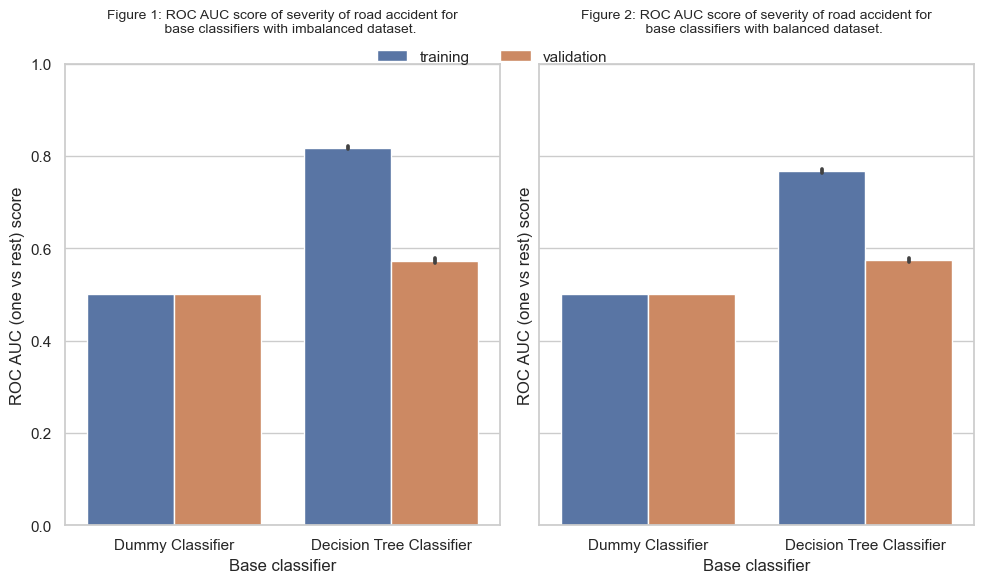

In [ ]:
results = pd.melt(results_df,id_vars = ['dataset','data type'],
                   value_vars=['Dummy Classifier','Decision Tree Classifier'])
new_line = '\n'
fig,axs = plt.subplots(1,2,figsize = (10,6),sharey = True)
for i,(data,ax) in enumerate(zip(list(results['dataset'].unique()),axs.ravel())):
    plotdata = results[results['dataset'] == data]
    sns.barplot(data=plotdata,
                x = 'variable',
                y = 'value',
                hue = 'data type',
                ax=ax)

    ax.set_title(f'Figure {1+i}: ROC AUC score of severity of road accident for{new_line}\
    base classifiers with {data}.', size = 10, y =1.05 )
    ax.set_xlabel("Base classifier")
    ax.set_ylabel("ROC AUC (one vs rest) score")
    ax.set_ylim(0,1)
    ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels,loc='center', bbox_to_anchor = (0.5,0.89), ncol=2,
              borderaxespad=0, frameon=False)
plt.tight_layout()
# show the graph
plt.show()

The Decision Tree returns a weighted average of the One vs Rest ROC AUC score of approximately 57% for the balanced dataset.

## Investigating the effect of order of categorical preprocessing and resampling.
### Experiment 1 - Effect of resampling prior to preprocessing on feature selection and model performance.
A combination of RUS and SMOTENC over a range of resampling amounts based on the proportion of the median class instances. Followed by preprocessing of categorical variables prior to performing Boruta algorithm for feature selection. A Random Forest is used as the comparative model  .

In [ ]:
from time import perf_counter
proportion_of_medians = [1,1.2,1.3]
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/cv_scores1/'
#Initialise the Random Forest estimator Feature Selection in Boruta algorithm
rf_boruta = RandomForestClassifier(n_estimators=75, n_jobs=-1, max_depth = 7, min_samples_leaf = 2)
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', max_iter = 35, perc = 85,verbose = 2)

#initialise model for fitting
rf =  RandomForestClassifier(n_estimators=350,n_jobs = -1,min_samples_split=8, max_depth = 15 , random_state=42)

training_validation1 = {}
t0 = perf_counter()
scores = []
score_type = []
dataset = []
prop = []
for i,proportion in enumerate(proportion_of_medians):
    # Split into training and validation sets

    for indx,(indx_train,indx_val) in enumerate(cv_splitter.split(X_train,y_train)):
        #define the training and validation sets
        X_traincv, X_validcv = X_train.iloc[indx_train], X_train.iloc[indx_val]
        y_traincv, y_validcv = y_train.iloc[indx_train], y_train.iloc[indx_val]

        # define the oversampling method for multiclass categorical and continuous variables
        over_sample1 = SMOTENC(categorical_features = cat_list,
                              categorical_encoder = OneHotEncoder(sparse_output = False),
                              sampling_strategy=over_under_sampling(X_traincv,y_traincv,proportion, t='minority'),
                              k_neighbors= 6,
                              random_state=12)

        # define the undersampling method for multiclass
        under_sample = RandomUnderSampler(sampling_strategy=over_under_sampling(X_traincv,y_traincv,proportion, t='majority'),
                                          random_state=12)
        #define the pipelines for resampling and preprocessing
        resampling_pipeline = Pipeline([('undersampling', under_sample),
                                        ('oversampling', over_sample1)])

         #define the pipelines for preprocessing
        process_pipeline = make_pipeline(drop_redundent,cat_encoding_preproc,cyclic_encoding_preproc)

        #########Perform resampling of training dataset##############
        # resample training data
        print(f'resampling with proportion of median of {proportion} at {(perf_counter()-t0)/60:0.2f} mins')
        X_traincv_balanced, y_traincv_balanced = resampling_pipeline.fit_resample(X_traincv,y_traincv)

        ######## perform pre-processing of training and testing set ##########
        print(f'Pre-processing data at {(perf_counter()-t0)/60: 0.2f} mins')
        #fit and transform training data
        X_traincv_balanced_trans = process_pipeline.fit_transform(X_traincv_balanced)
        #transform validation set
        X_validcv_trans = process_pipeline.transform(X_validcv)

        ########## Perform Feature Selection with Boruta Algorithm ############
        print(f'Commencing Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......')
        # fit training data
        boruta_selector.fit(np.array(X_traincv_balanced_trans),np.array(y_traincv_balanced))
        #transform training set
        X_traincv_filtered = boruta_selector.transform(X_traincv_balanced_trans.values)
        #transform validation set
        X_validcv_filtered = boruta_selector.transform(X_validcv_trans.values)
        print(f'Finished Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......{new_line}\
        cross_validating....')

        # fit the model
        rf.fit(X_traincv_filtered, y_traincv_balanced)
        # out of fold predictions on my validation set
        valid_pred = rf.predict(X_validcv_filtered)
        valid_predprob = rf.predict_proba(X_validcv_filtered)
        #training set predictions
        train_pred = rf.predict(X_traincv_filtered)
        train_predprob = rf.predict_proba(X_traincv_filtered)
        # scoring using roc_aucv and f1
        valid_auc_score = roc_auc_score(y_validcv, valid_predprob, multi_class = 'ovr', average = 'weighted')
        valid_f1_score = f1_score(y_validcv,valid_pred, average = 'weighted')
        train_auc_score = roc_auc_score(y_traincv_balanced, train_predprob, multi_class = 'ovr', average = 'weighted')
        train_f1_score = f1_score(y_traincv_balanced,train_pred, average = 'weighted')
        scores.append(train_auc_score)
        scores.append(train_f1_score)
        scores.append(valid_auc_score)
        scores.append(valid_f1_score)
        score_type.extend(['roc_auc score','f1 score']*2)
        dataset.extend(['training','training','validation','validation'])

    prop.extend([proportion]*(n*4))
    print(f'Finished cross-validation at {(perf_counter()-t0)/60: 0.2f} mins....{new_line}')
    # save the model to disk
training_validation1['values'] = scores
training_validation1['score type'] = score_type
training_validation1['dataset'] = dataset
training_validation1['proportion'] = prop
cv_scores_filename = 'cv_scores.csv'
pd.DataFrame(training_validation1).to_csv(PATH + cv_scores_filename)

resampling with proportion of median of 1 at 0.00 mins
Pre-processing data at  0.07 mins
Commencing Boruta Algorithm at  0.08 mins.......
Iteration: 	1 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	2 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	3 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	4 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	5 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	6 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	7 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	8 / 35
Confirmed: 	43
Tentative: 	5
Rejected: 	6
Iteration: 	9 / 35
Confirmed: 	43
Tentative: 	5
Rejected: 	6
Iteration: 	10 / 35
Confirmed: 	43
Tentative: 	5
Rejected: 	6
Iteration: 	11 / 35
Confirmed: 	43
Tentative: 	5
Rejected: 	6
Iteration: 	12 / 35
Confirmed: 	43
Tentative: 	5
Rejected: 	6
Iteration: 	13 / 35
Confirmed: 	43
Tentative: 	5
Rejected: 	6
Iteration: 	14 / 35
Confirmed: 	43
Tentative: 	4
Rejected: 	7
Ite

Evaluating the Random Forest classifier under the first strategy.

In [ ]:
### Retrieve testing data and fitted models
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/cv_scores1/'
# load the data into a pandas dataframe
files = glob.glob(PATH + "*.csv")
# read the csv files one at a time and concatenate to a dataframe.
t0 = perf_counter()
for i,file in enumerate(files):
    with open(file,encoding="utf-8") as dataFile:
        cv_scores = pd.read_csv(dataFile)
    print(f'Uploaded test data {i} in {(perf_counter()-t0)/60: 0.2f}mins')

Uploaded test data 0 in  0.00mins


In [ ]:
### The training and validation scores for two different metrics are plotted over a range of resampling proportions.
max_indx = cv_scores[(cv_scores['dataset'] =='validation')]['values'].argmax()
max_prop = cv_scores.loc[max_indx,'proportion']
max_score = cv_scores[cv_scores['dataset'] =='validation']['values'].max()
new_line = '\n'

fig,ax = plt.subplots(1,1,figsize = (7,5))

sns.lineplot(data = cv_scores,
            x = 'proportion',
            y = 'values',
            hue = 'dataset',
            style = 'score type',
            ax = ax)
ax.plot(max_prop,max_score,color = 'r',marker = 'o')
ax.annotate(f'maximum{new_line} ({max_prop: 0.2f}, {max_score:0.3f})',
        xy = (max_prop, max_score),
        xytext = (max_prop+0.01, max_score+0.01))
ax.legend().remove()
ax.set_title(f'Figure 2: ROC AUC and F1 score of severity of road accident for resampling portion of median class{new_line}\
(resampling before preprocessing).', size = 10, y =1.05 )
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("cross - validation score")
ax.set_xlabel("proportion of class median for resampling")
ax.set_ylim(0.4,1.1)
plt.figlegend(handles, labels,loc='center', bbox_to_anchor = (0.5,0.89), ncol=6,
              borderaxespad=0, frameon=False)

plt.tight_layout()
# show the graph
plt.show()

Varying the resampling proportion contributes very little variation to the out of fold cross - validation estimate of classifier performance.
The maximum performance achieved occurs at a ratio of 1, suggesting that limiting the oversamplig of the minority class would reduce over fitting and allow the model to generalise better.

### Experiment 2 -Effect of preprocessing prior to resampling on Feature selection and model performance.
Preprocessing of the dataset occurs first before resampling, followed by Boruta algorithm for feature selection. Resampling occurs only for the one level to the median of class instances in order to save time, especially since the previous experiment suggests little to know variation in performanc eestimate across resampling sizes.

In [ ]:
from time import perf_counter
proportion_of_medians = 1
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/cv_scores2/'
#Initialise the Random Forest estimator Feature Selection in Boruta algorithm
rf_boruta = RandomForestClassifier(n_estimators=75, n_jobs=-1, max_depth = 7, min_samples_leaf = 2)
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', max_iter = 35, perc = 85,verbose = 2)

#initialise model for fitting
rf =  RandomForestClassifier(n_estimators=350,n_jobs = -1,min_samples_split=8, max_depth = 15 , random_state=42)

training_validation2 = {}
t0 = perf_counter()
scores = []
score_type = []
dataset = []
prop = []

for indx,(indx_train,indx_val) in enumerate(cv_splitter.split(X_train,y_train)):
    #define the training and validation sets
    X_traincv, X_validcv = X_train.iloc[indx_train], X_train.iloc[indx_val]
    y_traincv, y_validcv = y_train.iloc[indx_train], y_train.iloc[indx_val]

    # define the oversampling method for multiclass continuous variables only.
    over_sample2 = SMOTE(sampling_strategy=over_under_sampling(X_traincv,y_traincv,proportion_of_medians, t='minority'),
                         k_neighbors= 6,
                         random_state=12)

    # define the undersampling method for multiclass
    under_sample = RandomUnderSampler(sampling_strategy=over_under_sampling(X_traincv,y_traincv,proportion_of_medians, t='majority'),
                                      random_state=12)
    #define the pipelines for resampling and preprocessing
    resampling_pipeline = Pipeline([('undersampling', under_sample),
                                    ('oversampling', over_sample2)])

     #define the pipelines for preprocessing
    process_pipeline = make_pipeline(drop_redundent,cat_encoding_preproc,cyclic_encoding_preproc)

    ######## perform pre-processing of training and testing set ##########
    print(f'Pre-processing data at {(perf_counter()-t0)/60: 0.2f} mins')
    #fit and transform training data
    X_traincv_trans = process_pipeline.fit_transform(X_traincv)
    #transform validation set
    X_validcv_trans = process_pipeline.transform(X_validcv)

    #########Perform resampling of training dataset##############
    # resample training data
    print(f'resampling with proportion of median of {proportion_of_medians} at {(perf_counter()-t0)/60:0.2f} mins')
    X_traincv_trans_balanced, y_traincv_balanced = resampling_pipeline.fit_resample(X_traincv_trans,y_traincv)

    ########## Perform Feature Selection with Boruta Algorithm ############
    print(f'Commencing Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......')
    # fit training data
    boruta_selector.fit(np.array(X_traincv_trans_balanced),np.array(y_traincv_balanced))
    #transform training set
    X_traincv_filtered = boruta_selector.transform(X_traincv_trans_balanced.values)
    #transform validation set
    X_validcv_filtered = boruta_selector.transform(X_validcv_trans.values)
    print(f'Finished Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......{new_line}\
    cross_validating....')

    # fit the model
    rf.fit(X_traincv_filtered, y_traincv_balanced)
    # out of fold predictions on my validation set
    valid_pred = rf.predict(X_validcv_filtered)
    valid_predprob = rf.predict_proba(X_validcv_filtered)
    #training set predictions
    train_pred = rf.predict(X_traincv_filtered)
    train_predprob = rf.predict_proba(X_traincv_filtered)
    # scoring using roc_aucv and f1
    valid_auc_score = roc_auc_score(y_validcv, valid_predprob, multi_class = 'ovr', average = 'weighted')
    valid_f1_score = f1_score(y_validcv,valid_pred, average = 'weighted')
    train_auc_score = roc_auc_score(y_traincv_balanced, train_predprob, multi_class = 'ovr', average = 'weighted')
    train_f1_score = f1_score(y_traincv_balanced,train_pred, average = 'weighted')
    scores.append(train_auc_score)
    scores.append(train_f1_score)
    scores.append(valid_auc_score)
    scores.append(valid_f1_score)
    score_type.extend(['roc_auc score','f1 score']*2)
    dataset.extend(['training','training','validation','validation'])
    print(f'Complete results for fold {indx+1} of cross validation at {(perf_counter()-t0)/60: 0.2f} mins....')

print(f'Finished cross-validation at {(perf_counter()-t0)/60: 0.2f} mins....{new_line}')
# save the model to disk
training_validation2['values'] = scores
training_validation2['score type'] = score_type
training_validation2['dataset'] = dataset
cv_scores_filename = 'cv_scores2.csv'
pd.DataFrame(training_validation2).to_csv(PATH + cv_scores_filename)

Pre-processing data at  0.00 mins
resampling with proportion of median of 1 at 0.01 mins
Commencing Boruta Algorithm at  0.01 mins.......
Iteration: 	1 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	2 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	3 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	4 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	5 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	6 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	7 / 35
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	8 / 35
Confirmed: 	46
Tentative: 	2
Rejected: 	6
Iteration: 	9 / 35
Confirmed: 	46
Tentative: 	2
Rejected: 	6
Iteration: 	10 / 35
Confirmed: 	46
Tentative: 	2
Rejected: 	6
Iteration: 	11 / 35
Confirmed: 	46
Tentative: 	2
Rejected: 	6
Iteration: 	12 / 35
Confirmed: 	46
Tentative: 	2
Rejected: 	6
Iteration: 	13 / 35
Confirmed: 	46
Tentative: 	2
Rejected: 	6
Iteration: 	14 / 35
Confirmed: 	46
Tentative: 	2
Rejected: 	6
Ite

Evaluate the Random Forest model fitted with selected feature of Baruta and using reversed order of preprocessing steps.

In [ ]:
### Retrieve testing data and fitted models
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/cv_scores2/'
# load the data into a pandas dataframe
files = glob.glob(PATH + "*.csv")
# read the csv files one at a time and concatenate to a dataframe.
t0 = perf_counter()
for i,file in enumerate(files):
    with open(file,encoding="utf-8") as dataFile:
        cv_scores2 = pd.read_csv(dataFile)
    print(f'Uploaded test data {i} in {(perf_counter()-t0)/60: 0.2f}mins')

Uploaded test data 0 in  0.00mins


Calculate the classification performance metric and represent graphically as Bar graphs.

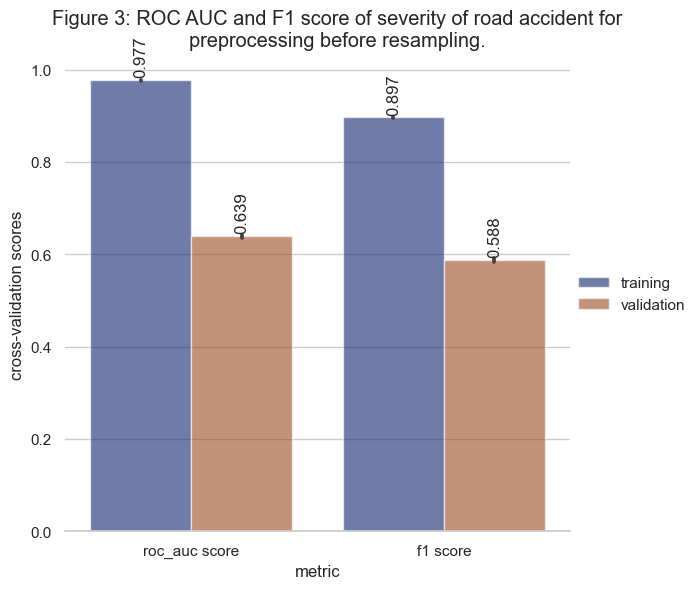

In [ ]:
### This experiment is reduced to onlycomparing
new_line = '\n'
# Draw a nested barplot
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=cv_scores2, kind="bar",
    x="score type", y="values", hue="dataset",
    palette="dark", alpha=.6, height=6,ax = ax)
g.despine(left=True)
g.set_axis_labels("metric", "cross-validation scores")
g.legend.set_title("")

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle(f'Figure 3: ROC AUC and F1 score of severity of road accident for{new_line}\
preprocessing before resampling.')
# auto-label bars
for container in g.ax.containers:
    g.ax.bar_label(container, fmt='%.3f', padding=2, rotation=90)


Very little improvement in cross-validation performation by preprocessing before resampling compared to what is demonstatrated under experiment 1.

### Experiment 3 - Effect of cost-sensitive learning with varying weight smoothing factors on model performance.
Examine the effect of using class weights with smoothing on the performance  of the model instead of under and over resampling. Varying class weights by logarithmic smoothing.

In [ ]:
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/cv_scores3/'
#Initialise the Random Forest estimator Feature Selection in Boruta algorithm
n = 2
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)
smoothing = [0,0.25,0.5,0.75,1]
training_validation3 = {}
t0 = perf_counter()
scores = []
score_type = []
dataset = []
prop = []
for i,value in enumerate(smoothing):

    for indx,(indx_train,indx_val) in enumerate(cv_splitter.split(X_train,y_train)):
        #define the training and validation sets
        X_traincv, X_validcv = X_train.iloc[indx_train], X_train.iloc[indx_val]
        y_traincv, y_validcv = y_train.iloc[indx_train], y_train.iloc[indx_val]

         #Initialise models and set Class Weights parameter
        class_weight = calculate_class_weights(y_train, smoothing = value)

        #Initialise the Random Forest estimator Feature Selection in Boruta algorithm
        rf_boruta = RandomForestClassifier(n_estimators=100,
                                           n_jobs=-1,
                                           max_depth = 7,
                                           min_samples_leaf = 2,
                                           class_weight = class_weight)

        boruta_selector = BorutaPy(rf_boruta,
                                   n_estimators='auto',
                                   max_iter = 30,
                                   perc = 85,
                                   verbose = 2)

        #initialise model for fitting
        rf =  RandomForestClassifier(n_estimators=350,
                                     n_jobs = -1,
                                     min_samples_split=10,
                                     max_depth = 20,
                                     random_state=42,
                                     class_weight = class_weight)

        #define the pipelines for preprocessing
        process_pipeline = make_pipeline(drop_redundent,cat_encoding_preproc,cyclic_encoding_preproc)

        ######## perform pre-processing of training and testing set ##########
        print(f'Pre-processing data at {(perf_counter()-t0)/60: 0.2f} mins')
        #fit and transform training data
        X_traincv_trans = process_pipeline.fit_transform(X_traincv)
        #transform validation set
        X_validcv_trans = process_pipeline.transform(X_validcv)

        ########## Perform Feature Selection with Boruta Algorithm ############
        print(f'Commencing Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......')
        # fit training data
        boruta_selector.fit(np.array(X_traincv_trans),np.array(y_traincv))
        #transform training set
        X_traincv_filtered = boruta_selector.transform(X_traincv_trans.values)
        #transform validation set
        X_validcv_filtered = boruta_selector.transform(X_validcv_trans.values)
        print(f'Finished Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......{new_line}\
        cross_validating....')

        # fit the model
        rf.fit(X_traincv_filtered, y_traincv)
        # out of fold predictions on my validation set
        valid_pred = rf.predict(X_validcv_filtered)
        valid_predprob = rf.predict_proba(X_validcv_filtered)
        #training set predictions
        train_pred = rf.predict(X_traincv_filtered)
        train_predprob = rf.predict_proba(X_traincv_filtered)
        # scoring using roc_aucv and f1
        valid_auc_score = roc_auc_score(y_validcv, valid_predprob, multi_class = 'ovr', average = 'weighted')
        valid_f1_score = f1_score(y_validcv,valid_pred, average = 'weighted')
        train_auc_score = roc_auc_score(y_traincv, train_predprob, multi_class = 'ovr', average = 'weighted')
        train_f1_score = f1_score(y_traincv,train_pred, average = 'weighted')
        scores.append(train_auc_score)
        scores.append(train_f1_score)
        scores.append(valid_auc_score)
        scores.append(valid_f1_score)
        score_type.extend(['roc_auc score','f1 score']*2)
        dataset.extend(['training','training','validation','validation'])
        print(f'Complete results for fold {indx+1} of cross validation at {(perf_counter()-t0)/60: 0.2f} mins....')

    prop.extend([value]*(n*4))
    print(f'Finished cross-validation at {(perf_counter()-t0)/60: 0.2f} mins....{new_line}')
        # save the model to disk
training_validation3['values'] = scores
training_validation3['score type'] = score_type
training_validation3['dataset'] = dataset
training_validation3['smoothing factor'] = prop
cv_scores_filename = 'cv_scores3.csv'
pd.DataFrame(training_validation3).to_csv(PATH + cv_scores_filename)

Pre-processing data at  0.00 mins
Commencing Boruta Algorithm at  0.01 mins.......
Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	30
Iteration: 	9 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	30
Iteration: 	10 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	30
Iteration: 	11 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	30
Iteration: 	12 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	30
Iteration: 	13 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	30
Iteration: 	14 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	30
Iteration: 	15 / 30
Confirmed: 	21
Tentative: 	3
Re

In [ ]:
### Retrieve testing data and fitted models
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/cv_scores3/'
# load the data into a pandas dataframe
files = glob.glob(PATH + "*.csv")
# read the csv files one at a time and concatenate to a dataframe.
t0 = perf_counter()
for i,file in enumerate(files):
    with open(file,encoding="utf-8") as dataFile:
        cv_scores3 = pd.read_csv(dataFile)
    print(f'Uploaded test data {i} in {(perf_counter()-t0)/60: 0.2f}mins')

Uploaded test data 0 in  0.00mins


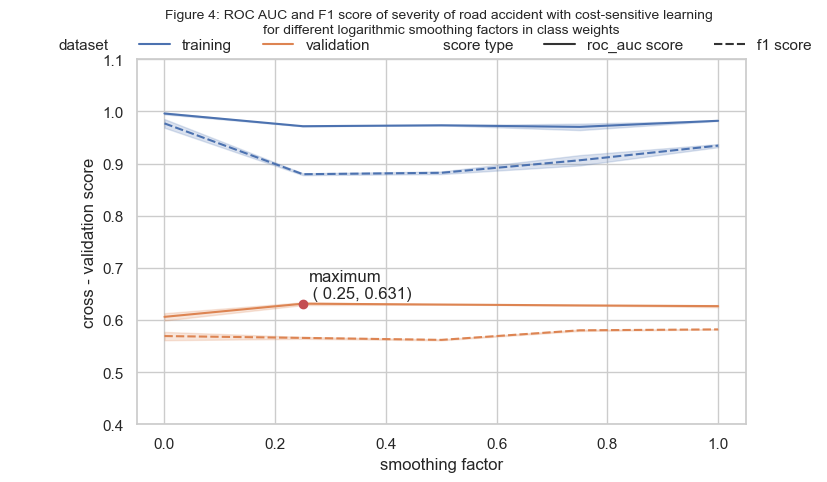

In [ ]:
averages = (cv_scores3[(cv_scores3['dataset'] == 'validation') & (cv_scores3['score type'] == 'roc_auc score')].groupby('smoothing factor')['values']
            .mean()
            .reset_index())
max_indx = averages['values'].argmax()
max_sf = averages.loc[max_indx,'smoothing factor']
max_score = averages['values'].max()
fig,ax = plt.subplots(1,1,figsize = (7,5))

sns.lineplot(data = cv_scores3,
             x = 'smoothing factor',
             y = 'values',
             hue = 'dataset',
             style = 'score type',
             errorbar=('ci', 95),
             ax = ax)
ax.plot(max_sf,max_score,color = 'r',marker = 'o')
ax.annotate(f'maximum{new_line} ({max_sf: 0.2f}, {max_score:0.3f})',
            xy = (max_sf, max_score),
            xytext = (max_sf+0.01, max_score+0.01))
ax.legend().remove()
ax.set_title(f'Figure 4: ROC AUC and F1 score of severity of road accident with cost-sensitive learning {new_line}\
for different logarithmic smoothing factors in class weights', size = 10, y =1.05 )
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("cross - validation score")
ax.set_xlabel("smoothing factor")
ax.set_ylim(0.4,1.1)
plt.figlegend(handles, labels,loc='center', bbox_to_anchor = (0.5,0.89), ncol=6,
              borderaxespad=0, frameon=False)

plt.tight_layout()
# show the graph
plt.show()

Cost-sensitive learning using a weighted Random Forest with untuned hyperparameters achieves a comparable out of fold generalisation estimate, but with a reduced feature set selected by Boruta algorithm and greatly reduced computation time. A Logarithmic smoothing factor of 0.25 gives the best result.

## Defining Classifier Models
The untuned  models are to be evaluated using cross validation. The models are looped through and the mean value and standard error of the scoring metrics of accuracy are determined under cross-validation.

In [ ]:
# define the class weights
class_weight = calculate_class_weights(y_train, smoothing = max_sf)
#create individual models
dummy = DummyClassifier()
dtc = DecisionTreeClassifier(max_depth=15,random_state = 42,class_weight = class_weight)
#initialise model for fitting
rfc =  RandomForestClassifier(n_estimators=350,
                             n_jobs = -1,
                             min_samples_split=8,
                             max_depth = 15 ,
                             random_state=42,
                             class_weight = class_weight)

adbc = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=5,class_weight = class_weight),learning_rate=0.1,random_state=42)

models = [dummy, dtc, rfc, adbc]

## Define the preprocessing, Feature Selection Strategy and Imbalanced data strategy
The data undergoes preprocessing to encode categorical variables. The Boruta algorithm is employed to select most relevant features, and  cost-sensitive learning is performed to fit weighted models to the transformed data.

In [ ]:
#Initialise the Random Forest estimator Feature Selection in Boruta algorithm
rf_boruta = RandomForestClassifier(n_estimators=350,
                                   n_jobs=-1,
                                   max_depth = 7,
                                   min_samples_leaf = 2,
                                   class_weight = class_weight)

boruta_selector = BorutaPy(rf_boruta,
                           n_estimators='auto',
                           max_iter = 40,
                           perc = 80,
                           verbose = 2)
 #define the pipelines for preprocessing
process_pipeline = make_pipeline(drop_redundent,cat_encoding_preproc,cyclic_encoding_preproc)
#fit and transform training dataset
X_train_trans = process_pipeline.fit_transform(X_train)
#transform the testing dataset
X_test_trans = process_pipeline.transform(X_test)
#fit the boruta feature selector
boruta_selector.fit(np.array(X_train_trans),np.array(y_train))
#transform training set
X_train_filtered = boruta_selector.transform(X_train_trans.values)
# Assign feature names back to dataset
X_train_filtered = pd.DataFrame(X_train_filtered,columns = X_train_trans.columns[boruta_selector.support_])
#transform the testing dataset
X_test_filtered = boruta_selector.transform(X_test_trans.values)
# Assign feature names back to dataset
X_test_filtered = pd.DataFrame(X_test_filtered,columns = X_test_trans.columns[boruta_selector.support_])

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	54
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	30
Tentative: 	6
Rejected: 	18
Iteration: 	9 / 40
Confirmed: 	30
Tentative: 	6
Rejected: 	18
Iteration: 	10 / 40
Confirmed: 	30
Tentative: 	6
Rejected: 	18
Iteration: 	11 / 40
Confirmed: 	30
Tentative: 	6
Rejected: 	18
Iteration: 	12 / 40
Confirmed: 	30
Tentative: 	6
Rejected: 	18
Iteration: 	13 / 40
Confirmed: 	30
Tentative: 	6
Rejected: 	18
Iteration: 	14 / 40
Confirmed: 	30
Tentative: 	5
Rejected: 	19
Iteration: 	15 / 40
Confirmed: 	30
Tentative: 	5
Rejected: 	19
Iteration: 	16 / 40
Confirmed: 	30
Tentative: 	5
Rejected: 	19
Iteratio

The Random Forest and AdaBoost models are trained and evaluated under cross validation. Results are compared to baseline measure of model performance estimate.

In [ ]:
n = 5
#defind cross-validation splitting
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)
model_scores = {}
# loop over the model pipelines
metrics = ['f1_weighted', 'roc_auc_ovr_weighted']
model_name = ['Dummy','Decision Tree','Random Forest','AdaBoost']
for i,model in enumerate(models):
    # perform cross validation to get cv performance scores
    cv_results = cross_validate(model,
                                X_train_filtered,
                                y_train,
                                scoring = metrics,
                                cv = cv_splitter,
                                n_jobs=-1,
                                verbose = 3)

    scores = []
    for metric in metrics:

        # determine mean, standard deviation and standard error of cv performance metric
        metric_mean = cv_results['test_' + metric].mean()
        metric_stdev = cv_results['test_'+ metric].std()
        metric_sterr = metric_stdev/np.sqrt(n)

        # mean cross validationm scores with error
        metric_result = f'{metric_mean: .3f} \u00B1 {2*metric_sterr: .3f}'

        scores.append(metric_result)

    # append model name and cv score to list
    model_scores[model_name[i]] = scores

results_df = pd.DataFrame(model_scores,index = ['f1_score','ROC_AUC'])
results_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.9s remaining:   26.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


,Dummy,Decision Tree,Random Forest,AdaBoost
f1_score,0.429 ± 0.000,0.555 ± 0.005,0.566 ± 0.002,0.555 ± 0.001
ROC_AUC,0.500 ± 0.000,0.574 ± 0.006,0.645 ± 0.003,0.560 ± 0.001


In [ ]:
The Random Forest algorithm achieves the best cross-validation scores.

# Hyper parameter tuning
The hyper parameters of each model are tuned using a hybrid approach of Randomised Search and Grid Search cross validation. The Randomised search identifies a ball park value for the optimum hyper parameter, while the grid seach will conduct a finer search within a range of some percentage either side of the value.

### define hyperparameters searches distributions

In [ ]:
n = 3
sample_size = len(X_train)

#defind cross-validation splitting
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)
# Random Forest Classifier parameters
n_estimators_range = sample(range(100, 230), 130)
weak_max_depth_range = sample(range(2, 10), 8)
base_max_depth_range = sample(range(10, 20), 10)
min_samples_split_range =  sample(range(round(2*sample_size//500,-1), round(3*sample_size//500,-1)),50)
min_samples_leaf_range = sample(range(round(3*sample_size//1000,-1), round(5*sample_size//1000,-1)),50)
#AdaBoost parameter ranges
learning_rate_range = np.logspace(-3,-2,50)

#AdaBoost Classifier parameters
random_param_adbc = {'n_estimators':n_estimators_range,
                     'learning_rate': learning_rate_range,
                     'estimator__max_depth':weak_max_depth_range}

#RF parameters
random_param_rfc = {'n_estimators' : n_estimators_range,
                    'max_depth': base_max_depth_range,
                    'min_samples_split' : min_samples_split_range,
                    'min_samples_leaf' : min_samples_leaf_range}

# parameters
parameters =  [random_param_rfc,
              random_param_adbc]
#models
models = [rfc, adbc]
model_names = ['Random Forest','AdaBoost']
# Conduct random search within the region of the optimal hyperparameters
half_tuned_models = {}

PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/models/'
with open(PATH + 'half_tuned_models.pickle', 'wb') as handle1:

    for i,model in enumerate(models):
        random_grid = RandomizedSearchCV(model,
                                         parameters[i],
                                         n_iter = 75,
                                         cv = cv_splitter,
                                         scoring = metrics,
                                         refit='roc_auc_ovr_weighted',
                                         n_jobs = -1,
                                         verbose = 3)
        # fit the model
        random_grid.fit(X_train_filtered, y_train)

        # Get the best hyperparameters from the random search
        best_random = random_grid.best_params_

        new_line = '\n'
        print(f'{random_grid.estimator} has best hyper parameters for Randomised search are: {new_line}\
        {best_random}')

        half_tuned_models[model_names[i]] = best_random

        # Save models
        pickle.dump(random_grid,handle1,pickle.HIGHEST_PROTOCOL)

with open(PATH + 'best_params_random_search.pickle', 'wb') as handle2:
    pickle.dump(half_tuned_models, handle2, protocol=pickle.HIGHEST_PROTOCOL)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
RandomForestClassifier(class_weight={0: 2.4774368838836365, 1: 0.8, 2: 0.8},
                       max_depth=15, min_samples_split=8, n_estimators=350,
                       n_jobs=-1, random_state=42) has best hyper parameters for Randomised search are: 
        {'n_estimators': 220, 'min_samples_split': 244, 'min_samples_leaf': 144, 'max_depth': 17}
Fitting 3 folds for each of 75 candidates, totalling 225 fits
AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 2.4774368838836365,
                                                                  1: 0.8,
                                                                  2: 0.8},
                                                    max_depth=5),
                   learning_rate=0.1, random_state=42) has best hyper parameters for Randomised search are: 
        {'n_estimators': 163, 'learning_rate': 0.002811768697974231, 'estimator__max_depth': 6}


## Gridsearch hyperparameter tuning
Using the best parameters from the Randomised search tuning, a further grid search is conducted to find the most optimal values. The grid search range of hyper parameter values is define with a width proportion, wp, either side of the best value identified from the randomised search. The number of values in the grid search is defined as the given parameter n.

In [ ]:
data = open(PATH + 'best_params_random_search.pickle', 'rb')
#defining the hyperparameter space ranges
best_params = pickle.load(data)

# proportion of width
wp = 0.075
# number of values
n = 4
# Random Forest Classifier parameters
n_estimators_range = best_params['Random Forest']['n_estimators'] + np.arange(-20, 20, 10)
max_depth_range = best_params['Random Forest']['max_depth'] + np.arange(-2,2,1)
min_samples_split_range =  best_params['Random Forest']['min_samples_split'] + np.arange(-20,20,10)
min_samples_leaf_range = best_params['Random Forest']['min_samples_leaf'] + np.arange(-20,20,10)

#AdaBoost Classifier parameter ranges
learning_rate_range2 = best_params['AdaBoost']['learning_rate']*(1 + np.arange(-wp, wp, 2*wp/(n-1)))
n_estimators_range2 = best_params['AdaBoost']['n_estimators'] + np.arange(-20, 20, 10)
max_depth_range2 = best_params['AdaBoost']['estimator__max_depth'] + np.arange(-2,2,1)

#RF parameters
gridsearch_param_rf = {'n_estimators' : n_estimators_range,
                       'max_depth': max_depth_range,
                       'min_samples_split' : min_samples_split_range,
                       'min_samples_leaf' : min_samples_leaf_range}

#AdaBoost Classifier parameters
gridsearch_param_adbc = {'n_estimators':n_estimators_range2,
                         'learning_rate': learning_rate_range2,
                         'estimator__max_depth':max_depth_range2}

# parameters
parameters2 = [gridsearch_param_rf,gridsearch_param_adbc]

# Perform Gridsearch
with open(PATH + 'full_tuned_models.pickle', 'wb') as handle3:
    for i,model in enumerate(models):
        gridsearch = GridSearchCV(model,
                                  parameters2[i],
                                  cv = cv_splitter,
                                  scoring = metrics,
                                  refit='roc_auc_ovr_weighted',
                                  n_jobs = -1,
                                  verbose=3)
        # fit the model
        gridsearch.fit(X_train_filtered, y_train)

        # Save final models
        pickle.dump(gridsearch, handle3,pickle.HIGHEST_PROTOCOL)


Fitting 3 folds for each of 256 candidates, totalling 768 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


### Extreme Gradient Boost model

### Sample weights
A Weighted XGBoost algorithm requires a sample weights vector as derived from class weights.

In [ ]:
#Create an array of sample weights for multiclass
def sample_weights(y,class_weight):
    #initialise with ones
    sample_weights_multiclass = np.ones(len(y))
    for class_,weight_ in class_weight.items():
        sample_weights_multiclass[y == class_] = weight_
    return sample_weights_multiclass

### Fit untuned model and evaluate cross-validation
The Weighted XGBoost model with default parameters out of the box is fitted to the data and evaluated under cross - validation. It is compared to the other model performance estimates.

In [ ]:
n = 10
#defind cross-validation splitting
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)

results={}
result1=[]
result2=[]
for train_index, valid_index in cv_splitter.split(X_train_filtered,y_train):
    X_train_xg, X_valid_xg = X_train_filtered.iloc[train_index], X_train_filtered.iloc[valid_index]
    y_train_xg, y_valid_xg = y_train[train_index],  y_train[valid_index]

    #definew class weights for training set
    class_weight_training = calculate_class_weights(y_train_xg, smoothing = max_sf)

    #definew class weights for validation set
    class_weight_validation = calculate_class_weights(y_valid_xg, smoothing = max_sf)

    #define sample weights for training
    sample_weight_training = sample_weights(y_train_xg,class_weight_training)

    #define sample weights for training
    sample_weight_validation = sample_weights(y_valid_xg,class_weight_validation)

    #initialise  classifier
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

    #fit the model
    xgb_model.fit(X_train_xg,
                  y_train_xg,
                  sample_weight = sample_weight_training,
                  early_stopping_rounds = 10,
                  eval_set = [(X_train_xg,y_train_xg),(X_valid_xg,y_valid_xg)],
                  eval_metric = ['auc','mlogloss'],
                  sample_weight_eval_set =[sample_weight_training,sample_weight_validation],
                  verbose = False)

    #for predictions
    y_pred_proba = xgb_model.predict_proba(X_valid_xg)
    y_pred = xgb_model.predict(X_valid_xg)
    #calculate metrics
    valid_auc_score = roc_auc_score(y_valid_xg, y_pred_proba, multi_class = 'ovr', average = 'weighted')
    valid_f1_score = f1_score(y_valid_xg,y_pred, average = 'weighted')
    #append results of metrics to list
    result1.append(valid_auc_score)
    result2.append(valid_f1_score)
results[metrics[1]] = result1
results[metrics[0]] = result2
scores = []
for metric in metrics:

    # determine mean, standard deviation and standard error of cv performance metric
    metric_mean = np.mean(results[metric])
    metric_stdev = np.std(results[metric])
    metric_sterr = metric_stdev/np.sqrt(n)

    # mean cross validationm scores with error
    metric_result = f'{metric_mean: .3f} \u00B1 {2*metric_sterr: .3f}'

    scores.append(metric_result)

# append model name and cv score to list
model_scores["XGBoost"] = scores

pd.DataFrame(model_scores,index = ['f1_score','ROC_AUC'])

,Dummy,Decision Tree,Random Forest,AdaBoost,XGBoost
f1_score,0.429 ± 0.000,0.555 ± 0.005,0.566 ± 0.002,0.555 ± 0.001,0.577 ± 0.004
ROC_AUC,0.500 ± 0.000,0.574 ± 0.006,0.645 ± 0.003,0.560 ± 0.001,0.644 ± 0.005


The Weighted XGBoost model generalisation estimate is comparable to that of the Weighted Random Forest model. The Learning Curve of the XGBoost model is observed to examine the extent of its training.

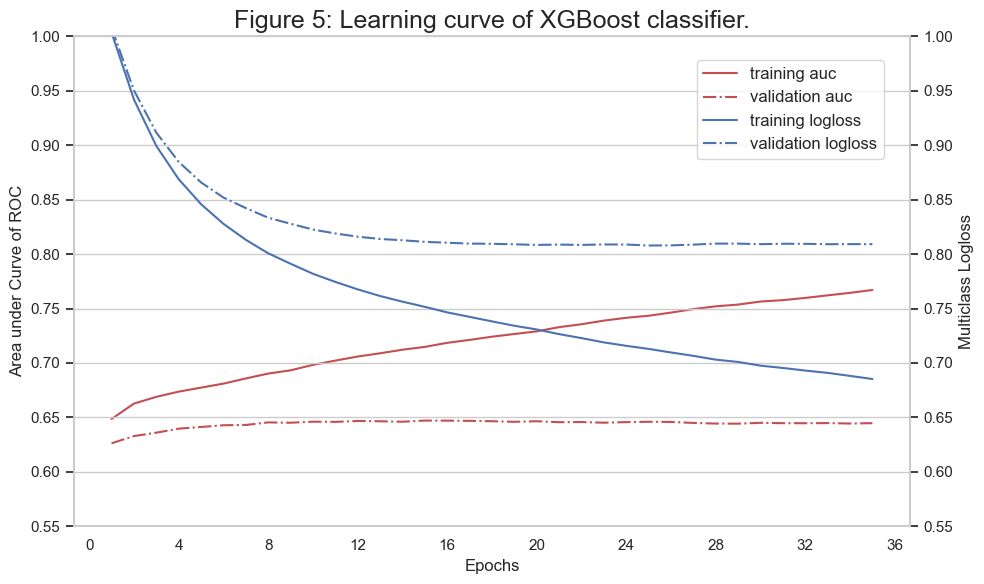

In [ ]:
lines = ['-r','-.r','-b','-.b']
labels = ['training auc','validation auc','training logloss','validation logloss']
fig,ax = plt.subplots(1,1,figsize = (10,6))
# retrieve performance metrics
results = xgb_model.evals_result()
# plot learning curves
epochs = [x for x in range(1,len(results['validation_0']['auc'])+1)]
  #define the current dictionary
data = results.copy()
# define the number of epochs
data['validation_0']['epochs'] = epochs
data['validation_1']['epochs'] = epochs
#plot the accuracy metric
l1, = ax.plot('epochs','auc',lines[0],data = data['validation_0'],label = labels[0])
l2, = ax.plot('epochs','auc',lines[1],data = data['validation_1'],label = labels[1])
ax.grid(False)
ax2 = ax.twinx()
l3, = ax2.plot('epochs','mlogloss',lines[2], data = data['validation_0'],label = labels[2])
l4, = ax2.plot('epochs','mlogloss',lines[3], data = data['validation_1'],label = labels[3])
ax2.grid(True)
  #label the axis
ax.set_ylabel("Area under Curve of ROC")
ax.set_xlabel("Epochs")
#set the range on the axis
ax.set_ylim(0.55,1)
ax2.set_ylabel("Multiclass Logloss")
ax2.set_ylim(0.55,1)
# Add sub titles per graph
ax.set_title(f"Figure 5: Learning curve of XGBoost classifier.",size = 18)
#have x-axis as integer tick labels
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#position the legend
fig.legend((l1,l2,l3,l4), labels, loc='outside right upper',bbox_to_anchor=(0.9, 0.9),prop={'size': 12})
fig.tight_layout()
#produces the graph
plt.show()

figure 5 shows that as the training epochs increase the training score continues to improve while the validation score plateaus. This is indicative of model overfitting and so model regularisation is to be considered when tuning the model.


### Tune Hyperparameters of XGBoost model

In [ ]:
n = 4
#defind cross-validation splitting
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)

# Create a custom estimator by inheriting from BaseEstimator and ClassifierMixin
class XGBSklearnEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, objective='multi:softmax', num_class=None, **params):
        self.objective = objective
        self.num_class = num_class
        self.params = params
        self.model = None

    def fit(self, X, y, sample_weights=None):
        if sample_weights is not None:
            dtrain = xgb.DMatrix(X, label=y, weight=sample_weights, nthread = -1)
        else:
            dtrain = xgb.DMatrix(X, label=y, nthread = -1)

        if self.num_class is not None:
            self.params['num_class'] = self.num_class

        self.model = xgb.train(params=self.params, dtrain=dtrain, early_stopping_rounds = 5)

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.model.predict(dtest)

    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.model.predict_proba(dtest)

#define sample weights for training
class_weight_training = calculate_class_weights(y_train, smoothing = max_sf)
sample_weight_training = sample_weights(y_train,class_weight_training)

#define the random parameters distributions
random_params_xgb = {"colsample_bytree": uniform(0.3, 1),
                     "gamma": uniform(0, 0.5),
                     "learning_rate": uniform(0.01, 0.3), # default 0.1
                     "min_child_weight":randint(1, 10), #default 1
                     "max_depth": randint(2, 12), # default 3
                     "n_estimators": randint(100, 200), # default 100
                     "subsample": uniform(0.4, 1),
                     "reg_lambda": uniform(0,2), # L2 regularisation
                     "reg_alpha": uniform(0,2)}  # L1 regularisation

# Perform Gridsearch
with open(PATH + 'tuned_model_xgb2.pickle', 'wb') as handle4:

    # Create an instance of the custom estimator
    #xgb_estimator = XGBSklearnEstimator(num_class = 3)  # Provide the number of classes
    xgb_model = xgb.XGBClassifier(objective="multi:softprob",
                                  random_state=42)

    random_grid_xgb = RandomizedSearchCV(xgb_model,
                                         random_params_xgb,
                                         n_iter = 100,
                                         cv = cv_splitter,
                                         scoring = metrics,
                                         refit='roc_auc_ovr_weighted',
                                         n_jobs =-1,
                                         verbose = 3)

    # Fit RandomizedSearchCV to your data
    random_grid_xgb.fit(X_train_filtered, y_train, sample_weight = sample_weight_training)

    # Get the best hyperparameters from the random search
    best_random_xgb = random_grid_xgb.best_params_

    new_line = '\n'
    print(f'{random_grid_xgb.estimator} has best hyper parameters for Randomised search are: {new_line}\
    {best_random_xgb}')
    # Save final models
    pickle.dump(random_grid_xgb, handle4,pickle.HIGHEST_PROTOCOL)

with open(PATH + 'best_params_model_xgb2.pickle', 'wb') as handle5:
    pickle.dump(best_random_xgb, handle5, protocol=pickle.HIGHEST_PROTOCOL)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) has best hyper parameters for Randomised search are: 
    {'colsample_bytree': 0.3247276533034375, 'gamma': 0.3061625701859781, 'learning_rate': 0.028767567334610666, 'max_dept

## Stacking Ensemble Classifier
THe stacking ensemble will take the tuned models in the first layer as the base learners and the final learning will be a Logistic model .

In [ ]:
n=5
#defind cross-validation splitting
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/models/'
learner_ensemble = []
final_model_grids = []
final_models = []
with open(PATH+'full_tuned_models.pickle', 'rb') as handle5:
    while True:
        try:
            final_model_grids.append(pickle.load(handle5))
        except EOFError:
            break
with open(PATH+'tuned_model_xgb2.pickle', 'rb') as handle6:
    while True:
        try:
            final_model_grids.append(pickle.load(handle6))
        except EOFError:
            break
#define sample weights for training
class_weight_training = calculate_class_weights(y_train, smoothing = max_sf)
sample_weight_training = sample_weights(y_train,class_weight_training)

model_name = ['Random_Forest','AdaBoost','XGBoost']
for i,(model_grid,name) in enumerate(zip(final_model_grids,model_name)):
    #retrieve CV score stats for model
    mean_acc = model_grid.best_score_
    stdev_acc = model_grid.cv_results_['std_test_roc_auc_ovr_weighted'][model_grid.best_index_]
    sterr_acc = stdev_acc/np.sqrt(4)
    # mean cross validation scores with error
    metric_result = f'{mean_acc: .3f} \u00B1 {2*sterr_acc: .3f}'
    print(f'{name} has CV roc auc {metric_result}')
    #Ensemble classifier 2 - Stack of estimators with a final classifier.
    learner_ensemble.append((name,model_grid.best_estimator_))
    final_models.append(model_grid.best_estimator_)
#produce stacking classifier model
ensemble_model1 = StackingClassifier(estimators=learner_ensemble,
                                     cv = cv_splitter,
                                     stack_method='predict_proba',
                                     final_estimator = LogisticRegression(),
                                     n_jobs = -1,
                                     passthrough = False
                                     )
#fit model
ensemble_model1.fit(X_train_filtered,y_train, **{'sample_weight' :sample_weight_training})
print('Stacking ensemble classifier fitted. Evaluating with cross validation')
cv_results_ensemble = cross_validate(ensemble_model1,
                                     X_train_filtered,
                                     y_train,
                                     scoring ='roc_auc_ovr_weighted',
                                     cv = cv_splitter,
                                     n_jobs=-1,
                                     verbose = 3)
acc_mean = cv_results_ensemble['test_score'].mean()
acc_stdev = cv_results_ensemble['test_score'].std()
acc_sterr = acc_stdev/np.sqrt(n)
# mean cross validationm scores with error
metric_result = f'{acc_mean: .3f} \u00B1 {2*acc_sterr: .3f}'
print(f'Stacked model has CV roc auc {metric_result}')

final_models.append(ensemble_model1)
with open(PATH + 'final_models.pickle', 'wb') as handle7:
    pickle.dump(final_models, handle7, protocol=pickle.HIGHEST_PROTOCOL)

Random_Forest has CV accuracy  0.642 ±  0.001
AdaBoost has CV accuracy  0.624 ±  0.001
XGBoost has CV accuracy  0.648 ±  0.003
Stacking ensemble classifier fitted. Evaluating with cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.2min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min finished


Stacked model has CV accuracy  0.649 ±  0.003


The Stacking Ensemble model returns the highest cross-validation score compared to the other models.

# Evaluation of the Classifiers

Produce Confusion Matrices and Calssification Report for each classifier model.

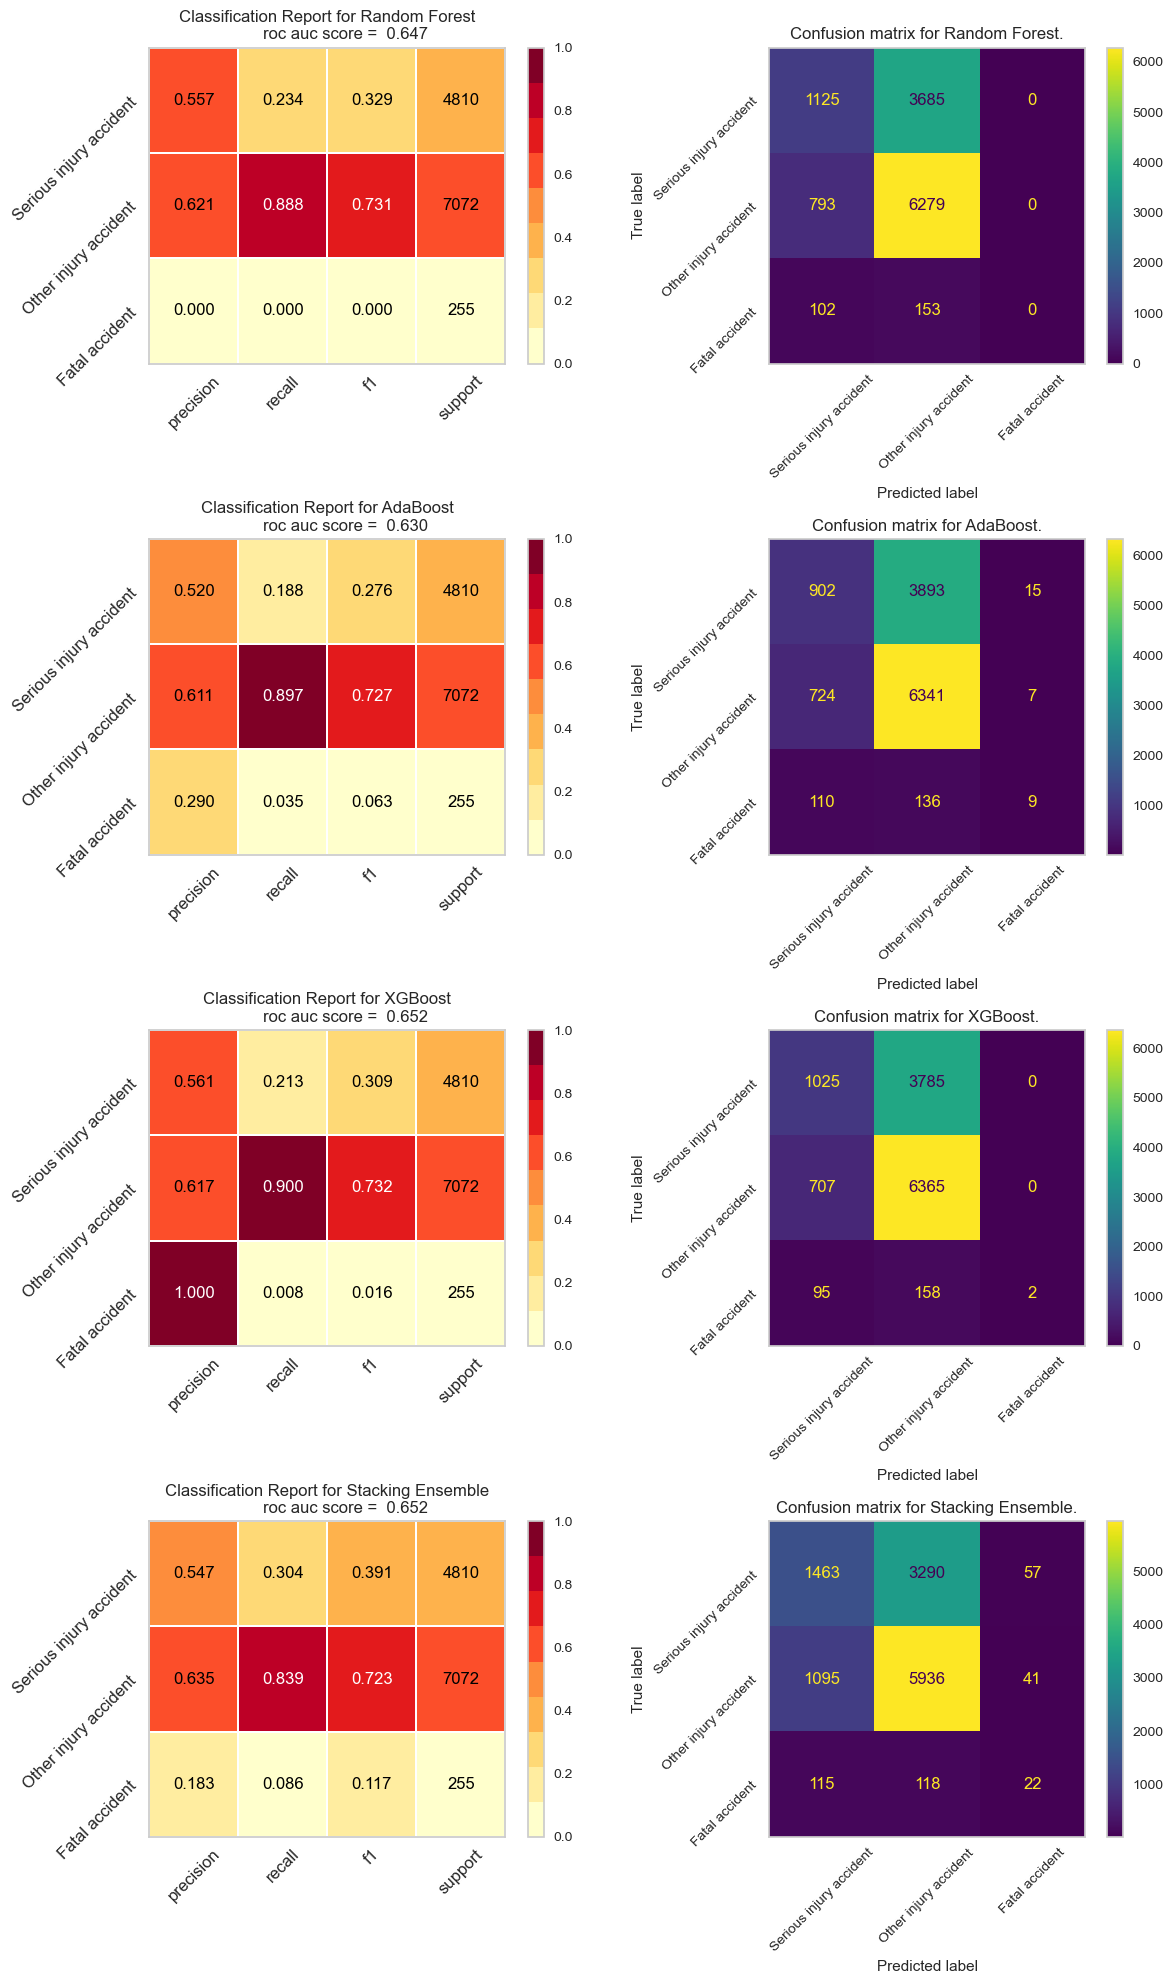

In [ ]:
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/models/'
with open(PATH+'final_models.pickle', 'rb') as handle8:
    while True:
        try:
            final_models = pickle.load(handle8)
        except EOFError:
            break
fig,axs = plt.subplots(4,2,figsize=(12, 20))
model_name = ['Random Forest','AdaBoost','XGBoost','Stacking Ensemble']
classes = ['Serious injury accident', 'Other injury accident','Fatal accident']
for i,ax in enumerate(axs.ravel()):
    if i % 2 == 0:

        #for predictions
        y_pred_proba = final_models[i//2%4].predict_proba(X_test_filtered)
        #calculate metrics
        test_auc_score = roc_auc_score(y_test, y_pred_proba, multi_class = 'ovr', average = 'weighted')

        visualizer = ClassificationReport(final_models[i//2%4],
                                          support=True,
                                          classes = classes,
                                          is_fitted=True,
                                          ax = ax)
        visualizer.fit(X_train_filtered, y_train)        # Fit the visualizer and the model
        visualizer.score(X_test_filtered, y_test)        # Evaluate the model on the test data
        ax.set_yticklabels(labels = ax.get_yticklabels(), rotation = 45)
        ax.set_title(f"Classification Report for {model_name[i//2%4]}{new_line}\
        roc auc score = {test_auc_score: 0.3f}",**{'fontsize': 12}, loc='center')


    else:
        ConfusionMatrixDisplay.from_estimator(final_models[i//2%4],
                                              X_test_filtered,
                                              y_test,
                                              labels = np.array([2,1,0]),
                                              display_labels = classes,
                                              ax = ax)
                                          #display_labels=np.unique(le.inverse_transform(y)))
        ax. grid(False)
        ax.set_yticklabels(labels = ax.get_yticklabels(), rotation = 45)
        ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45)
        ax.set_title(label=f"Confusion matrix for {model_name[i//2%4]}.",**{'fontsize': 12}, loc='center')
plt.tight_layout()

plt.savefig('figure 3.png')

## Feature Importance
The importance of features for each model is determined via permutation importance

Completed feature importance calculation for Random Forest in  1.03 minutes.
Completed feature importance calculation for AdaBoost in  2.97 minutes.
Completed feature importance calculation for XGBoost in  3.34 minutes.
Completed feature importance calculation for Stacking Ensemble in  6.53 minutes.


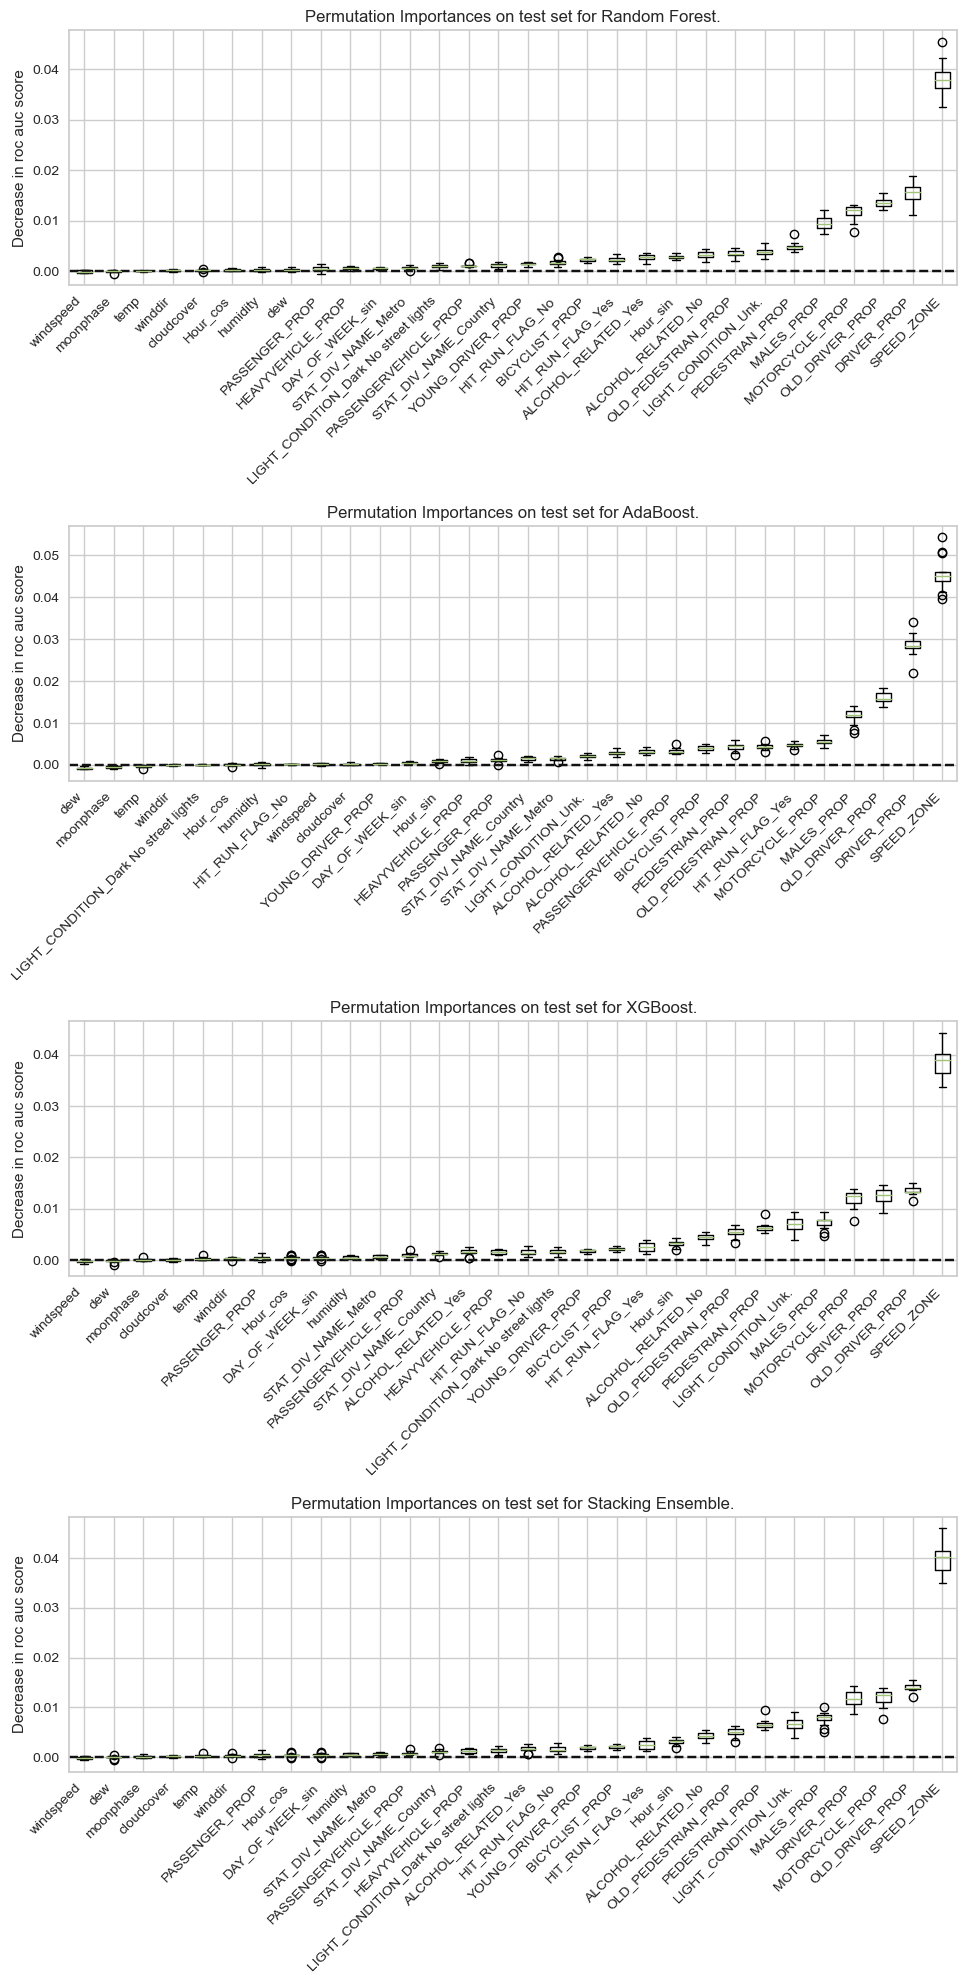

In [ ]:
fig,axs = plt.subplots(4,1,figsize = (10,20))
axs = axs.ravel()
start_time = perf_counter()
for i,(model,name) in enumerate(zip(final_models, model_name)):
    perm_result = permutation_importance(model,
                                    X_test_filtered,
                                    y_test,
                                    n_repeats=15,
                                    scoring = 'roc_auc_ovr_weighted',
                                    random_state=42,
                                    n_jobs=-1)
    # sort the features by their importance score
    sorted_importances_idx = perm_result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_test_filtered.columns[sorted_importances_idx])
    axs[i].boxplot(importances,labels  = importances.columns)
    axs[i].set_title(f"Permutation Importances on test set for {name}.")
    axs[i].axhline(y=0, color="k", linestyle="--")
    axs[i].set_ylabel("Decrease in roc auc score")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation = 45,ha="right")
    print(f"Completed feature importance calculation for {name} in {(perf_counter()-start_time)/60: 0.2f} minutes.")
plt.tight_layout()
plt.show()

## Shapley Additive Explanations (SHAP) analysis
Feature importance is examined by determining Shapley Values.

In [ ]:
shap_results = []
shap_models = list((final_models[0],final_models[2]))
for model in shap_models:
    explainer = shap.TreeExplainer(model)
    #Calculate the SHAP values
    shap_result = explainer.shap_values(X_test_filtered)
    shap_results.append(shap_result)

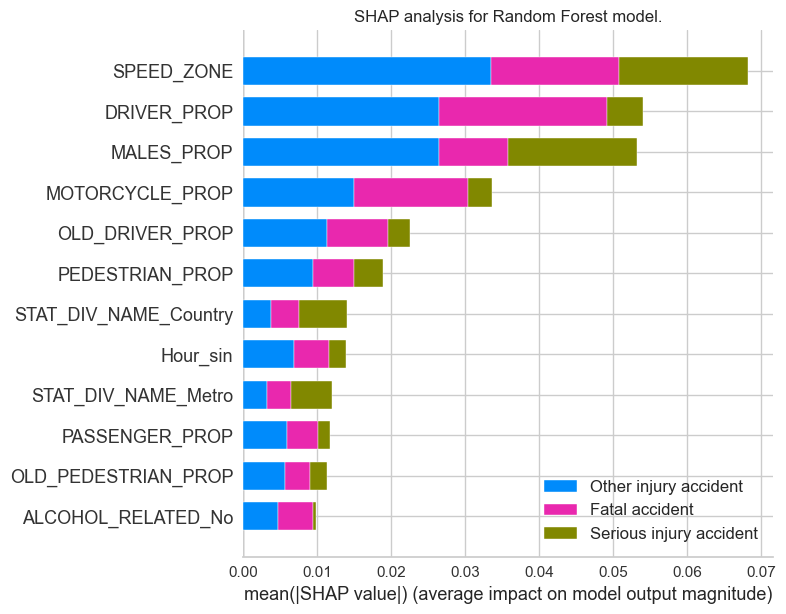

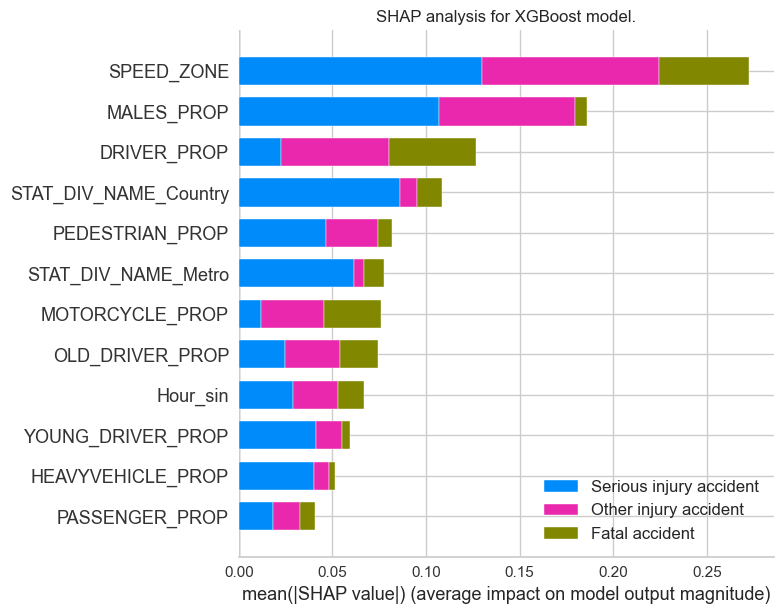

In [ ]:
model_names = ['Random Forest','XGBoost']
for result,name in zip(shap_results, model_names):
    title = f'SHAP analysis for {name} model.'
    plt.title(title)
    shap.summary_plot(result,
                      features=X_test_filtered,
                      feature_names=X_test_filtered.columns,
                      max_display=12,
                      plot_type = 'bar',
                      class_names= ['Serious injury accident','Other injury accident','Fatal accident'])


## Changes in Configuration to improve the solution.
1. Use resampling strategy of RUS and SMOTE instead of cost sensitive learning using class weights. Fit, retune and evaluate the models.

The categorical features are preprocessed prior to resampling, then automated feature selection is performed under Boruta algorithm.

In [ ]:
########### Define Preprocessing Steps ############
# define the oversampling method for multiclass continuous variables only.
over_sample3 = SMOTE(sampling_strategy=over_under_sampling(X_train,y_train,1, t='minority'),
                     k_neighbors= 10,
                     random_state=12)

# define the undersampling method for multiclass
under_sample = RandomUnderSampler(sampling_strategy=over_under_sampling(X_train,y_train,1, t='majority'),
                                  random_state=12)
#define the pipelines for resampling and preprocessing
resampling_pipeline2 = Pipeline([('undersampling', under_sample),
                                ('oversampling', over_sample3)])
#define the pipelines for preprocessing
process_pipeline2 = make_pipeline(drop_redundent,cat_encoding_preproc,cyclic_encoding_preproc)

#Initialise the Random Forest estimator Feature Selection in Boruta algorithm
rf_boruta2 = RandomForestClassifier(n_estimators=250,
                                   n_jobs=-1,
                                   max_depth = 7)

boruta_selector2 = BorutaPy(rf_boruta2,
                           n_estimators='auto',
                           max_iter = 25,
                           perc = 100,
                           verbose = 2)
t0 = perf_counter()
######## perform pre-processing of training and testing set ##########
#fit and transform training data
X_train_trans = process_pipeline2.fit_transform(X_train)
#transform validation set
X_test_trans = process_pipeline2.transform(X_test)
print(f'Pre-processing data complete: {(perf_counter()-t0)/60: 0.2f} mins')
#########Perform resampling of training dataset##############
# resample training data
X_train_trans_balanced, y_train_balanced = resampling_pipeline2.fit_resample(X_train_trans,y_train)
print(f'resampling complete at {(perf_counter()-t0)/60:0.2f} mins')
########## Perform Feature Selection with Boruta Algorithm ############
print(f'Commencing Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......')
# fit training data
boruta_selector2.fit(np.array(X_train_trans_balanced),np.array(y_train_balanced))
#transform training set
X_train_filtered2 = boruta_selector2.transform(X_train_trans_balanced.values)
# Assign feature names back to dataset
X_train_filtered2 = pd.DataFrame(X_train_filtered2,columns = X_train_trans_balanced.columns[boruta_selector2.support_])
#transform validation set
X_test_filtered2 = boruta_selector2.transform(X_test_trans.values)
# Assign feature names back to dataset
X_test_filtered2 = pd.DataFrame(X_test_filtered2,columns = X_test_trans.columns[boruta_selector2.support_])
print(f'Finished Boruta Algorithm at {(perf_counter()-t0)/60: 0.2f} mins.......')


Pre-processing data complete:  0.01 mins
resampling complete at 0.01 mins
Commencing Boruta Algorithm at  0.01 mins.......
Iteration: 	1 / 25
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	2 / 25
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	3 / 25
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	4 / 25
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	5 / 25
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	6 / 25
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	7 / 25
Confirmed: 	0
Tentative: 	51
Rejected: 	0
Iteration: 	8 / 25
Confirmed: 	42
Tentative: 	3
Rejected: 	6
Iteration: 	9 / 25
Confirmed: 	42
Tentative: 	3
Rejected: 	6
Iteration: 	10 / 25
Confirmed: 	42
Tentative: 	3
Rejected: 	6
Iteration: 	11 / 25
Confirmed: 	42
Tentative: 	3
Rejected: 	6
Iteration: 	12 / 25
Confirmed: 	43
Tentative: 	2
Rejected: 	6
Iteration: 	13 / 25
Confirmed: 	43
Tentative: 	2
Rejected: 	6
Iteration: 	14 / 25
Confirmed: 	43
Tentative: 	2
Rejected: 	6
Iteration: 	15 / 2

The algorithm returns a larger subset of the feature space compared to the pevious configuration. This will incur a significant increase in computation time.

Perform a single Random Search for Hyperparameter tuning for the Random Forest, AdaBoost and XGBoost models.

In [ ]:
n = 3
sample_size = len(X_train_filtered2)

###### Define the models ############
# Random Forest
rfc2 =  RandomForestClassifier(random_state=42)
# AdaBoost model
adbc2 = AdaBoostClassifier(estimator = DecisionTreeClassifier(),random_state=42)
# XGBoost model
xgb2 = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

#defind cross-validation splitting
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)

# Random Forest Classifier parameters
n_estimators_range = sample(range(100, 250), 150)
weak_max_depth_range = sample(range(2, 12), 10)
base_max_depth_range = sample(range(10, 25), 15)
min_samples_split_range =  sample(range(round(2*sample_size//500,-1), round(3*sample_size//500,-1)),50)
min_samples_leaf_range = sample(range(round(3*sample_size//1000,-1), round(5*sample_size//1000,-1)),50)
#AdaBoost parameter ranges
learning_rate_range = np.logspace(-2,0,100)

#XGBoost parameter ranges
regularisation_range = uniform(0,2)
subsampling_range = uniform(0.2, 1)
gamma_range = uniform(0, 0.8)
min_child_weight_range = randint(1, 10)

#AdaBoost Classifier parameters distributions
random_param_adbc = {'n_estimators':n_estimators_range,
                     'learning_rate': learning_rate_range,
                     'estimator__max_depth':weak_max_depth_range}

#RF parameters
random_param_rfc = {'n_estimators' : n_estimators_range,
                    'max_depth': base_max_depth_range,
                    'min_samples_split' : min_samples_split_range,
                    'min_samples_leaf' : min_samples_leaf_range}

#define the random parameters distributions for xgboost
random_params_xgb = {"colsample_bytree": subsampling_range,
                     "gamma": gamma_range,
                     "learning_rate": learning_rate_range,
                     "min_child_weight":min_child_weight_range, #default 1
                     "max_depth": weak_max_depth_range, # default 3
                     "n_estimators": n_estimators_range, # default 100
                     "subsample": subsampling_range,
                     "reg_lambda": regularisation_range, # L2 regularisation
                     "reg_alpha": regularisation_range}  # L1 regularisation

# parameters list
parameters =  [random_param_rfc,
              random_param_adbc,
              random_params_xgb]
#models
models = [rfc2, adbc2, xgb2]
model_names = ['Random Forest','AdaBoost','XGBoost']
# Conduct random search within the region of the optimal hyperparameters

PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/models2/'
with open(PATH + 'tuned_models2.pickle', 'wb') as handle10:

    for i,model in enumerate(models):
        random_grid = RandomizedSearchCV(model,
                                         parameters[i],
                                         n_iter = 100,
                                         cv = cv_splitter,
                                         scoring = 'roc_auc_ovr',
                                         n_jobs = -1,
                                         verbose = 3)
        # fit the model
        random_grid.fit(X_train_filtered2, y_train_balanced)
        # Get the best hyperparameters from the random search
        best_random = random_grid.best_params_

        print(f'{random_grid.estimator} has best hyper parameters for Randomised search are: {new_line}\
        {best_random}')

        # Save models
        pickle.dump(random_grid,handle10,pickle.HIGHEST_PROTOCOL)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
RandomForestClassifier(random_state=42) has best hyper parameters for Randomised search are: 
        {'n_estimators': 216, 'min_samples_split': 249, 'min_samples_leaf': 170, 'max_depth': 17}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
n=5
#defind cross-validation splitting
cv_splitter = StratifiedKFold(n_splits = n, shuffle= True, random_state= 42)
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/models2/'
learner_ensemble2 = []
final_model_grids2 = []
final_models2 = []
with open(PATH+'tuned_models2.pickle', 'rb') as handle11:
    while True:
        try:
            final_model_grids2.append(pickle.load(handle11))
        except EOFError:
            break

model_names = ['Random Forest','AdaBoost','XGBoost']
for i,(model_grid,name) in enumerate(zip(final_model_grids2,model_names)):
    #retrieve CV score stats for model
    mean_acc = model_grid.best_score_
    stdev_acc = model_grid.cv_results_['std_test_roc_auc_ovr_weighted'][model_grid.best_index_]
    sterr_acc = stdev_acc/np.sqrt(n)
    # mean cross validation scores with error
    metric_result = f'{mean_acc: .3f} \u00B1 {2*sterr_acc: .3f}'
    print(f'{name} has CV roc auc {metric_result}')
    #Ensemble classifier 2 - Stack of estimators with a final classifier.
    learner_ensemble2.append((name,model_grid.best_estimator_))
    final_models2.append(model_grid.best_estimator_)
#produce stacking classifier model
ensemble_model2 = StackingClassifier(estimators=learner_ensemble2,
                                     cv = cv_splitter,
                                     stack_method='predict_proba',
                                     final_estimator = LogisticRegression(),
                                     n_jobs = -1,
                                     passthrough = False)
#fit model
ensemble_model2.fit(X_train_filtered2,y_train_balanced)
print('Stacking ensemble classifier fitted. Evaluating with cross validation')
cv_results_ensemble2= cross_validate(ensemble_model2
                                     X_train_filtered2,
                                     y_train_balanced,
                                     scoring ='roc_auc_ovr_weighted',
                                     cv = cv_splitter,
                                     n_jobs=-1,
                                     verbose = 3)
acc_mean = cv_results_ensemble2['test_score'].mean()
acc_stdev = cv_results_ensemble2['test_score'].std()
acc_sterr = acc_stdev/np.sqrt(n)
# mean cross validationm scores with error
metric_result = f'{acc_mean: .3f} \u00B1 {2*acc_sterr: .3f}'
print(f'Stacked model has CV roc auc {metric_result}')

final_models2.append(ensemble_model2)
with open(PATH + 'final_models2.pickle', 'wb') as handle12:
    pickle.dump(final_models2, handle12, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
PATH = 'C:/Users/08632717/Documents/Masters of Data Science Study/Masters Program/Big Data Analysis Industry Project/models2/'
with open(PATH+'final_models2.pickle', 'rb') as handle13:
    while True:
        try:
            final_models2 = pickle.load(handle13)
        except EOFError:
            break
fig,axs = plt.subplots(4,2,figsize=(12, 20))
model_name = ['Random Forest','AdaBoost','XGBoost','Stacking Ensemble']
classes = ['Serious injury accident', 'Other injury accident','Fatal accident']
for i,ax in enumerate(axs.ravel()):
    if i % 2 == 0:

        #for predictions
        y_pred_proba = final_models[i//2%4].predict_proba(X_test_filtered)
        #calculate metrics
        test_auc_score = roc_auc_score(y_test, y_pred_proba, multi_class = 'ovr', average = 'weighted')

        visualizer = ClassificationReport(final_models[i//2%4],
                                          support=True,
                                          classes = classes,
                                          is_fitted=True,
                                          ax = ax)
        visualizer.fit(X_train_filtered, y_train)        # Fit the visualizer and the model
        visualizer.score(X_test_filtered, y_test)        # Evaluate the model on the test data
        ax.set_yticklabels(labels = ax.get_yticklabels(), rotation = 45)
        ax.set_title(f"Classification Report for {model_name[i//2%4]}{new_line}\
        roc auc score = {test_auc_score: 0.3f}",**{'fontsize': 12}, loc='center')


    else:
        ConfusionMatrixDisplay.from_estimator(final_models[i//2%4],
                                              X_test_filtered,
                                              y_test,
                                              labels = np.array([2,1,0]),
                                              display_labels = classes,
                                              ax = ax)
                                          #display_labels=np.unique(le.inverse_transform(y)))
        ax. grid(False)
        ax.set_yticklabels(labels = ax.get_yticklabels(), rotation = 45)
        ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45)
        ax.set_title(label=f"Confusion matrix for {model_name[i//2%4]}.",**{'fontsize': 12}, loc='center')
plt.tight_layout()

plt.savefig('figure 3.png')